In [5]:
import copy
from termcolor import colored
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  


In [65]:


def transpose(l):
    return list(map(list, zip(*l)))  # thanks stack overflow

class GridReader(object):
    def __init__(self, filein, lookup_dict, min_len=2):
        self.row_cols = []
        with open(filein) as f:
            for line in f:
                line = line.rstrip()
                self.row_cols.append(list(line))
        self.lookup_dict = lookup_dict
        self.min_len = min_len
        self.leny = len(self.row_cols)
        self.lenx = len(self.row_cols[0])
        # validate matrix is consistent
        for row in self.row_cols:
            assert len(row) == self.lenx

        # matrix for pretty printing
        self.colorme = []
        colorrow = []
        for row in self.row_cols:
            for c in row:
                colorrow.append(0)
            self.colorme.append(colorrow)
            colorrow = []

    def get_words(self, row_like):
        out = []
        j = 0
        for row in row_like:
            for word, i in words_in_string(row, self.lookup_dict, self.min_len):
                out.append((''.join(word), j, i))
            j += 1
        return out
        # row = i, start_column = j


    def mark(self, row, col, length, direction):
        if direction == 'e':
            for i in range(length):
                self.colorme[row][col + i] += 1
        elif direction == 's':
            for i in range(length):
                self.colorme[row + i][col] += 1
        elif direction == 'ne':
            for i in range(length):
                self.colorme[row - i][col + i] += 1
        elif direction == 'se':
            for i in range(length):
                self.colorme[row + i][col + i] += 1
        else:
            raise ValueError('direction must be in "e", "s", "ne", "se"')

    def row_words(self):
        row_like = copy.deepcopy(self.row_cols)
        for word, row, col in self.get_words(row_like):
            yield word, row, col, 'e', len(word)

    def col_words(self):
        col_like = copy.deepcopy(self.row_cols)
        for word, col, row in self.get_words(transpose(col_like)):
            yield word, row, col, 's', len(word)

    def get_diagonal_words(self, row_like):
        out = []
        for substring, ystart, xstart in diagonal(row_like, self.min_len):
            for word, i in words_in_string(substring, self.lookup_dict, self.min_len):
                out.append((''.join(word), ystart + i, xstart + i))
        return out

    def diagonal_down_words(self):
        for word, y, x in self.get_diagonal_words(self.row_cols):
            yield word, y, x, 'se', len(word)

    def diagonal_up_words(self):
        ymax = len(self.row_cols)
        mat = copy.deepcopy(self.row_cols)
        mat.reverse()
        for word, y, x in self.get_diagonal_words(mat):
            yield word, ymax - y - 1, x, 'ne', len(word)


    def find_all_words(self):
        out = []
        out += list(self.row_words())
        out += list(self.col_words())
        out += list(self.diagonal_down_words())
        out += list(self.diagonal_up_words())
        for word, row, col, direction, length in out:
            self.mark(row, col, length, direction)
        return out

    def __str__(self):
        return '\n'.join([''.join([x for x in y]) for y in self.row_cols])

    def pretty_print(self):
        colors = {0: 'grey', 1: 'green', 2: 'blue', 3: 'cyan',  4: 'yellow', 5: 'red', 6: 'magenta', 7: 'white'}
        #print('\n'.join([''.join([str(x) for x in y]) for y in self.colorme]))
        for y in range(self.leny):
            for x in range(self.lenx):
                c = self.row_cols[y][x]
                col_i = min(self.colorme[y][x], max(colors.keys()))  # only support up to 5 overlapping words
                col = colors[col_i]
                print(colored(c, col), end='')
            print('')

def get_or_make(a_dict, key):
    if key not in a_dict:
        a_dict[key] = {}
    return a_dict[key]


def make_lookup_dict(word_iter, min_len=2):
    lookup_dict = {}
    shortest = 100
    for word in word_iter:
        shortest = min(len(word), shortest)
        word = [x.lower() for x in word]
        if len(word) < min_len:
            continue
        iword = iter(word)
        char = next(iword)
        current = get_or_make(lookup_dict, char)
        for char in iword:
            current = get_or_make(current, char)
        current['EOW'] = True
    return lookup_dict, shortest


def read_lines(filein):
    with open(filein) as f:
        for line in f:
            line = line.rstrip()
            yield line


def is_word(lookup, query):
    iquery = iter([x.lower() for x in query])
    current = lookup
    for char in iquery:
        try:
            current = current[char]
        # not a word if we run out of lookup dictionary before query
        except KeyError:
            word = False
            keep_trying = False
            return word, keep_trying

    if 'EOW' in current:
        word = True
        keep_trying = True
        if len(current) == 1:
            keep_trying = False  # was the only word that started with that
        return word, keep_trying
    else:
        word = False
        keep_trying = True
        # if we ran out of query, but not marked as End of word in lookup dict
        return word, keep_trying


# for reading the board
# make a function that gets continuous strings in all angles
# start at 0, while keep_trying keep extending, then increment start
#
def words_in_string(letters, lookup, minlen=2):
    i = 0
    while len(letters) >= minlen:
        for word in words_from_start(letters, lookup, minlen):
            yield word, i
        letters.pop(0)
        i += 1


def words_from_start(string, lookup, minlen=2):
    keep_trying = True
    i = minlen
    while keep_trying and (i <= len(string)):
        query = string[:i]
        i += 1
        is_a_word, keep_trying = is_word(lookup, query)
        if is_a_word:
            yield query

def diagonal(mat, min_len=2):
    xby = 1
    yby = 1
    current = []
    xstop = len(mat[0])
    ystop = len(mat)
    for xstart in range(xstop):
        y = 0
        x = xstart
        while 0 <= x < xstop and 0 <= y < ystop:
            current.append(mat[y][x])
            y += yby
            x += xby
        if len(current) >= min_len:
            yield current, 0, xstart
        current = []
    for ystart in range(1, ystop):
        x = 0
        y = ystart
        while 0 <= x < xstop and 0 <= y < ystop:
            current.append(mat[y][x])
            y += yby
            x += xby
        if len(current) >= min_len:
            yield current, ystart, 0
        current = []

In [66]:
def increment_coord(x, y, direction):
    if direction == 'e':
        x = x + 1
        y = y
    elif direction == 's':
        y = y + 1
        x = x
    elif direction == 'ne':
        y = y - 1
        x = x + 1
    elif direction == 'se':
        x = x + 1
        y = y + 1
    return x, y

def overlaps_coord(start_coord, direction, length, target_coord):
    x, y = start_coord
    for _ in range(length):
        #print('x, y {} targ: {}'.format((x, y), target_coord))
        if (x, y) == target_coord:
            return True
        x, y = increment_coord(x, y, direction)

    return False
        

In [67]:
#filein = 'eff_large.wordlist'
filein = "Collins_Scrabble_Words_2015.txt"
words = read_lines(filein)
lookup_dict, shortest_word = make_lookup_dict(words, min_len=3)
shortest_word = 3

In [68]:

gr = GridReader('chargrid.txt', lookup_dict, shortest_word)
i = 0
count_overlap = 0
for sstr in gr.find_all_words():
    i += 1
    max_coord = (16, 6)
    overlaps = overlaps_coord(start_coord=(sstr[2], sstr[1]), direction=sstr[3], length=sstr[4], 
                              target_coord=max_coord)

    if overlaps:
        count_overlap += 1
        print(sstr)
    #print(sstr, overlaps)
    
print('{} total words found, {} overlapping {}'.format(i, count_overlap, max_coord))
#print(np.array(gr.colorme))
gr.pretty_print()

('UNWAVERING', 6, 11, 'e', 10)
('WAVE', 6, 13, 'e', 4)
('WAVER', 6, 13, 'e', 5)
('WAVERING', 6, 13, 'e', 8)
('AVE', 6, 14, 'e', 3)
('AVER', 6, 14, 'e', 4)
('ERING', 6, 16, 'e', 5)
('GAGE', 3, 16, 's', 4)
('AGE', 4, 16, 's', 3)
('GEO', 5, 16, 's', 3)
('GEE', 5, 15, 'se', 3)
('ZEE', 7, 15, 'ne', 3)
299 total words found, 12 overlapping (16, 6)
YWRTTVVDINIWQEZGCUIJEMGYUBXFJXYB
IUHLUOCQCQPVAFEFQPMKDVTYHCUOAGCX
KJXOTXWOZPRBPDZWSDZDMTBSSCOWHMSL
BYVCKFYXHRPBRMJDGIBYSPZEQBOJQTIB
TLDLYGWWKRAZFDDUAIPNOIVWSKYUJWAB
RZQKPDKKDHYINODGGEMFXBTGZGOPHCQX
EXVMNIFZAVUUNWAVERINGFOCUSDMESPE
PJTJWZUAIMKXLDQZOEMVZOUNTREGXNQL
CXNAZSCXBUMPDVRWAIEAENNTIBUOXOXX
UYHAUSOFZPRARZCDWGZLOJIBTBYNEBCH
HUYGBLTTWOWWSEWIGNYIPIXWJQLGNUFZ
SPHELVLLDSFCYUAYIMSCRPVWSEMMNGUC
IFJSOLUTIONSOWZJZJA...GXNF...FDS
NPMYHTKJBULHRWXAYNZ...SOEHP  JSU
XVQSTNPYZOSVPVQZOQX...JALSIBBCJU
KLPYADZVJZTDYMNAZYXD.PGEMRDKVIXD
UZMCRUHWJIRTUKDHXVDZTUSFBROJAHZT
UMBPFBUJYRAFDSBSPRQIITAEAEGLLMBM
MKDQKZZRSZTGKKMZJZRNVPHEGWYDUSQY
BMFFWPDHERERAFOFVATDIJCONFIDE

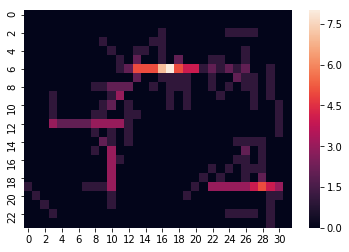

In [9]:
sns.heatmap(gr.colorme)

In [46]:
a = np.array(gr.colorme)

In [47]:
np.unravel_index(np.argmax(a, axis=None), a.shape)

(6, 16)

In [48]:
np.max(a)

12